<a href="https://colab.research.google.com/github/andrew-ryabchenko/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', parse_dates=['created'], index_col=['created'])
assert df.shape == (49352, 33)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
import seaborn as sns

In [4]:
# Mask for the test/train timeline split
mask = df.index <= pd.to_datetime('May 2016')

In [53]:
# Splitting the data
train_data = df[mask]
test_data = df[~mask]

In [56]:
train_data.groupby(['interest_level']).mean()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
interest_level,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.118464,1.567810,40.746338,-73.969038,2771.627451,0.471405,0.437908,0.532680,0.388889,0.290033,0.406863,0.459150,0.133987,0.193627,0.125000,0.174020,0.108660,0.187908,0.114379,0.089052,0.071895,0.047386,0.039216,0.058007,0.056373,0.054739,0.050654,0.030229,0.046569
2,1.166533,1.612267,40.746923,-73.972380,3165.609067,0.541333,0.421600,0.608533,0.388533,0.403200,0.502133,0.471467,0.077867,0.259200,0.165600,0.205067,0.160267,0.193867,0.130133,0.115200,0.069600,0.062133,0.064800,0.062133,0.030933,0.055733,0.053067,0.034400,0.035467
3,1.217913,1.476919,40.750770,-73.974097,3757.180379,0.526906,0.492395,0.440986,0.465445,0.451570,0.391977,0.331139,0.044205,0.275371,0.192564,0.170951,0.125322,0.125322,0.089211,0.078360,0.052121,0.054879,0.049720,0.040292,0.039936,0.044294,0.033888,0.027751,0.027840


In [6]:
# Verify if the split was correct

print(f'Train data time range: {train_data.index.month_name().value_counts()}')
print(f'Test data time range: {test_data.index.month_name().value_counts()}')

# Data is splitted correctly

Train data time range: April    16217
Name: created, dtype: int64
Test data time range: June    16973
May     15627
Name: created, dtype: int64


In [ ]:
# Engineering a new feature 'perk_score' which is weighted average of features present in building/appartment. Each feature is assigned 
# a 'weight' according to it's significance in determining the price of a rental. The maximum score with all features present is 10

feature_scores = {'exclusive': 14/105, 'new_construction': 5/105, 'doorman': 12/105, 'fitness_center': 11/105,
                  'elevator': 10/105, 'roof_deck': 9/105, 'outdoor_space': 6/105, 'laundry_in_unit': 7/105, 'dishwasher': 8/105,
                  'swimming_pool': 13/105, 'balcony': 4/105, 'laundry_in_building': 3/105, 'loft': 2/105,
                  'hardwood_floors': 1/105}

train_data['perk_score'] = (train_data['exclusive'] * feature_scores['exclusive'] + train_data['new_construction'] * feature_scores['new_construction'] \
                            + train_data['swimming_pool'] * feature_scores['swimming_pool'] + train_data['fitness_center'] * feature_scores['fitness_center'] \
                            + train_data['balcony'] * feature_scores['balcony'] + train_data['roof_deck'] * feature_scores['roof_deck'] \
                            + train_data['outdoor_space'] * feature_scores['outdoor_space'] + train_data['laundry_in_unit'] * feature_scores['laundry_in_unit'] \
                            + train_data['dishwasher'] * feature_scores['dishwasher'] + train_data['elevator'] * feature_scores['elevator'] \
                            + train_data['doorman'] * feature_scores['doorman'] + train_data['laundry_in_building'] * feature_scores['laundry_in_building'] \
                            + train_data['loft'] * feature_scores['loft'] + train_data['hardwood_floors'] * feature_scores['hardwood_floors']) * 10

test_data['perk_score'] = (test_data['exclusive'] * feature_scores['exclusive'] + test_data['new_construction'] * feature_scores['new_construction'] \
                            + test_data['swimming_pool'] * feature_scores['swimming_pool'] + test_data['fitness_center'] * feature_scores['fitness_center'] \
                            + test_data['balcony'] * feature_scores['balcony'] + test_data['roof_deck'] * feature_scores['roof_deck'] \
                            + test_data['outdoor_space'] * feature_scores['outdoor_space'] + test_data['laundry_in_unit'] * feature_scores['laundry_in_unit'] \
                            + test_data['dishwasher'] * feature_scores['dishwasher'] + test_data['elevator'] * feature_scores['elevator'] \
                            + test_data['doorman'] * feature_scores['doorman'] + test_data['laundry_in_building'] * feature_scores['laundry_in_building'] \
                            + test_data['loft'] * feature_scores['loft'] + test_data['hardwood_floors'] * feature_scores['hardwood_floors']) * 10

In [70]:
test_data.columns

Index(['bathrooms', 'bedrooms', 'description', 'display_address', 'latitude',
       'longitude', 'price', 'street_address', 'interest_level', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access', 'common_outdoor_space', 'room_total', 'zone',
       'perk_score'],
      dtype='object')

In [58]:
# Making new feature 'zone' that will denote the zone name for the appartment locations in listings. Zones will be ordered from least to the most
# expensive by average listing price. 

def zone_assign(lat):
# Financial District (2) lat =< 40.7107            1
# Downtown (5) 40.7107 < lat =< 40.7355            2
# Midtown (4) 40.7355 < lat =< 40.7635             3
# Upper ES/WS (3) 40.7635 < lat =< 40.7939         4  
# Uptown (1) lat > 40.7939                         5

  if (lat > 40.7939):
    return 1
  if (40.7635 < lat <= 40.7939):
    return 3
  if (40.7355 < lat <= 40.7635):
    return 4
  if (40.7107 < lat <= 40.7355):
    return 5
  if (lat <= 40.7107):
    return 2
  else:
    return 0

In [ ]:
test_data['zone'] = test_data['latitude'].apply(zone_assign)
train_data['zone'] = train_data['latitude'].apply(zone_assign)

In [ ]:
# Making new feature 'room_total' that will denote the sum of bathrooms and bedrooms for each listing.

test_data['room_total'] = test_data['bathrooms'] + test_data['bedrooms']
train_data['room_total'] = train_data['bathrooms'] + train_data['bedrooms']

In [ ]:
# Converting interest_level to the numerical value

def int_convert(x):
  if (x=='high'):
    return 1
  if (x=='medium'):
    return 2
  if (x=='low'):
    return 3

test_data['interest_level'] = test_data['interest_level'].apply(int_convert)
train_data['interest_level'] = train_data['interest_level'].apply(int_convert)

In [ ]:
# Building a model 
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [67]:
# Create target vectors

y_train = train_data['price']
y_test = test_data['price']

# Create feature matrices

X_train = train_data[['zone', 'interest_level', 'perk_score', 'room_total']]
X_test = test_data[[ 'zone', 'interest_level', 'perk_score', 'room_total']]

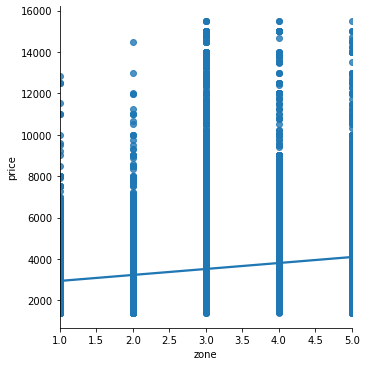

In [13]:
sns.lmplot(x='zone', y='price', data = test_data);

In [68]:
# Instanciate the model

model = LinearRegression()

# Fit the model into data

model.fit(X_train, y_train)

# Making prediction on test data
test_data_predictions = model.predict(X_test)

#Baseline $MAE$, $RMSE$, and $R^2$ for the test data.

In [39]:
baseline = test_data['price'].mean()
print(f'Baseline MAE: {mean_absolute_error(y_test, [baseline] * len(y_test))}')
print(f'Baseline RMSE: {mean_squared_error(y_test,[baseline] * len(y_test), squared=False)}')
print(f'Baseline r2: {r2_score(y_test, [baseline] * len(y_test))}')

Baseline MAE: 1213.8430739884827
Baseline RMSE: 1779.4147159119623
Baseline r2: 0.0


#Model $MAE$, $RMSE$, and $R^2$ for the test data.

In [69]:
print(f'Baseline MAE: {mean_absolute_error(y_test, test_data_predictions)}')
print(f'Baseline RMSE: {mean_squared_error(y_test,test_data_predictions, squared=False)}')
print(f'Baseline r2: {r2_score(y_test, test_data_predictions)}')

Baseline MAE: 740.7875599432058
Baseline RMSE: 1160.6249268967615
Baseline r2: 0.5745687070219685
